<a href="https://colab.research.google.com/github/SofiaShvedova/Data-analytics-tools-for-solving-applied-problems/blob/main/NPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. **DRY: Don't repeat yourself**
<p><img src="https://assets.datacamp.com/production/project_1234/img/survey.png" style="float: center;" alt="A" width="100%"></p>
<p>Вы когда-нибудь начинали анализ данных и заканчивали повторяющимся кодом? Бренда, работающая продуктовым аналитиком, оказалась в такой ситуации и обратилась к нам за помощью. Она написала скрипт для получения данных Net Promotor Score (NPS) из различных источников. NPS работает, задавая вопрос:
 
 <b> Насколько вероятно, что вы порекомендуете наш продукт другу или коллеге? со шкалой оценок от 0 до 10</b>.
 
  Бренда настроила этот опрос NPS различными способами, включая электронные письма и всплывающие окна в мобильном приложении и на сайте. Чтобы скомпилировать данные из разных источников, она написала следующий код:</p>
<pre><code class="py language-py"># Чтение ответов электронной почты NPS в DataFrame
email = pd.read_csv("datasets/2020Q4_nps_email.csv")
# добавление столбца почтового ресурса
email['source'] = 'email'

# Повторение для мобильных и веб-ответов NPS.
mobile = pd.read_csv("datasets/2020Q4_nps_mobile.csv")
mobile['source'] = 'mobile'
web = pd.read_csv("datasets/2020Q4_nps_web.csv")
web['source'] = 'web'

# Обьединение DataFrames
q4_nps = pd.concat([email,mobile,web])
</code></pre>
<p>This results in the DataFrame <code>q4_nps</code> that looks like this:</p>
<table>
<thead>
<tr>
<th></th>
<th><code>response_date</code></th>
<th><code>user_id</code></th>
<th><code>nps_rating</code></th>
<th><code>source</code></th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>2020-10-29</td>
<td>36742</td>
<td>2</td>
<td>email</td>
</tr>
<tr>
<td>1</td>
<td>2020-11-26</td>
<td>31851</td>
<td>10</td>
<td>email</td>
</tr>
<tr>
<td>2</td>
<td>2020-10-27</td>
<td>44299</td>
<td>10</td>
<td>email</td>
</tr>
<tr>
<td>…</td>
<td>…</td>
<td>…</td>
<td>…</td>
<td>…</td>
</tr>
</tbody>
</table>
<p> Этот код работает, но он нарушает принцип программирования <b> «Не повторяйся» (DRY)</b>. Бренда повторяет один и тот же код для электронной почты, мобильных устройств и Интернета, но с другими именами переменных и именами файлов. Хотя зачастую копирование и вставка выполняется быстрее, это упрощает внесение ошибок. Например, если вам нужно отредактировать одну из этих строк, вы должны сделать это в нескольких местах. Введите функции! Повторяющийся код — это признак того, что нам нужны функции. Давайте напишем функцию для Бренды.</p>

In [1]:
import pandas as pd


def convert_csv_to_df(csv_name, source_type):
    """ Converts an NPS CSV into a DataFrame with a column for the source. 

    Args:
        csv_name (str): The name of the NPS CSV file.
        source_type (str): The source of the NPS responses.

    Returns:
        A DataFrame with the CSV data and a column, source.
    """   
    df = pd.read_csv(csv_name)
    df['source'] = source_type
    return df

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 2020Q4_nps_email.csv to 2020Q4_nps_email.csv
Saving 2020Q4_nps_mobile.csv to 2020Q4_nps_mobile.csv
Saving 2020Q4_nps_web.csv to 2020Q4_nps_web.csv
Saving corrupted.csv to corrupted.csv
User uploaded file "2020Q4_nps_email.csv" with length 37531 bytes
User uploaded file "2020Q4_nps_mobile.csv" with length 34419 bytes
User uploaded file "2020Q4_nps_web.csv" with length 44042 bytes
User uploaded file "corrupted.csv" with length 45787 bytes


In [3]:
# Test the function on the mobile data: 
convert_csv_to_df("2020Q4_nps_mobile.csv", "mobile")

,response_date,user_id,nps_rating,source
0,2020-12-29,14178,3,mobile
1,2020-10-29,33221,1,mobile
2,2020-11-01,21127,10,mobile
3,2020-12-07,42894,3,mobile
4,2020-11-26,30501,5,mobile
...,...,...,...,...
1796,2020-12-29,49529,3,mobile
1797,2020-12-24,23671,7,mobile
1798,2020-11-28,39954,7,mobile
1799,2020-12-19,21098,7,mobile


---
## 2. Проверка файлов с помощью ключевого слова "with" 
<p>
Отлично, у нас есть функция, которая читает и очищает CSV-файлы Бренды именно так, как ей нужно! Она может вызывать эту функцию в будущем для любого количества различных источников. Прежде чем мы объединим NPS DataFrames, мы хотим добавить функцию, которая проверяет правильность введенных файлов. Каждый из этих файлов набора данных NPS должен иметь три столбца: 

1.   <code>response_date</code>, 
2.   <code>user_id</code>,
3.   <code>nps_rating</code>. 

Раньше Бренда проверяла это вручную, открывая каждый файл. </p>
<p>Давайте напишем функцию, которая использует <strong>менеджер контекста</strong> <code>with open()</code>, чтобы правильно закрывать открываемые файлы, <a href="https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files">даже если возникнет исключение</a>. Если мы не используем ключевое слово <code>with</code> с <code>open()</code> , нам нужно будет вызвать <code>close()</code> после того, как мы закончим с фабудет считанйл. Даже в этом случае это рискованно, поскольку ошибка может возникнуть до вызова функций <code>close()</code>. </p>
<p>The Функция вернет <code>True</code>, если файл содержит правильные столбцы. В противном случае он вернет <code>False</code>. Чтобы протестировать функцию, мы будем использовать <code>datasets/corrupted.csv</code> для имитации поврежденного недействительного файла NPS.</p>

In [4]:
def check_csv(csv_name):
    """ Checks if a CSV has three columns: response_date, user_id, nps_rating

    Args:
        csv_name (str): The name of the CSV file.

    Returns:
        Boolean: True if the CSV is valid, False otherwise 
    """
    with open(csv_name) as f:
        first_line = f.readline()
        # Return true if the CSV has the three specified columns:
        if first_line == "response_date,user_id,nps_rating\n":
            return True

        return False




In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving corrupted.csv to corrupted.csv
User uploaded file "corrupted.csv" with length 45787 bytes


In [5]:
# Test the function on a corrupted NPS file:
print(check_csv('corrupted.csv'))

False


## 3. Использование вложенных функций
<p>
Хорошо, теперь у нас есть одна функция, которая проверяет правильность файлов CSV, и другая, которая преобразует их в формат DataFrame, необходимый Бренде. Что осталось? Глядя на сценарий, это последняя строка, которую мы не рассмотрели: <code>q4_nps = pd.concat([email,mobile,web])</code>. Мы могли бы использовать эту строку кода, но мы увидим больше повторений кода, если получим файлы CSV из других источников или периодов времени.</p>
<p>Чтобы наш код был масштабируемым, мы напишем функцию <code>combine_nps_csvs()</code>, которая принимает словарь. В словарях Python есть пары ключ:значение. В нашем случае имя CSV и тип источника будут ключом и значением соответственно. Таким образом, мы можем определить словарь с любым количеством файлов NPS и запустить его с помощью <code>combine_nps_csvs()</code>. Для каждого файла мы проверим, что он действителен, используя <code>check_csv()</code>, и если это так, мы будем использовать <code>convert_csv_to_df()</code>, чтобы преобразовать его в DataFrame. В начале функции мы определим пустой DataFrame с именем <code>combined</code>, и каждый раз, когда CSV будет успешно преобразован, мы будем объединять его в <code>combined</code>.</p>

In [6]:
def combine_nps_csvs(csvs_dict):
    # Define combine as an empty DataFrame:
    combined = pd.DataFrame()

    # Iterate over csvs_dict to get the name and source of the CSVs:
    for name, source in csvs_dict.items():
        # Check if the csv is valid:
        if check_csv(name):
            # Convert the CSV using convert_csv_to_df():
            temp = convert_csv_to_df(name, source)
            # Concatenate combined and temp:
            combined = pd.concat([combined, temp])

        # If the file is not valid, print a message with the CSV's name:
        else:
            print(name + " is not a valid file and will not be added.")

    # Return the combined DataFrame
    return combined

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [7]:
my_files = {
  "2020Q4_nps_email.csv": "email",
  "2020Q4_nps_mobile.csv": "mobile",
  "2020Q4_nps_web.csv": "web",
  "corrupted.csv": "social_media"
}

# Test the function on the my_files dictionary:
combine_nps_csvs(my_files)

corrupted.csv is not a valid file and will not be added.


,response_date,user_id,nps_rating,source
0,2020-11-06,11037,7,email
1,2020-12-24,34434,9,email
2,2020-12-03,49547,8,email
3,2020-10-04,13821,7,email
4,2020-10-23,29407,9,email
...,...,...,...,...
2285,2020-12-25,10656,8,web
2286,2020-11-07,32918,10,web
2287,2020-10-16,15667,10,web
2288,2020-11-20,47153,7,web


---
## 4. Детрактор, нейтралы и промоутеры
<p>
Объединим скрипт в одну функцию: <code>combine_nps_csvs()</code>! Перейдем к анализу данных NPS, например, к фактическому расчету NPS. Он работает, задавая вопрос 

<em>Насколько вероятно, что вы порекомендуете наш продукт другу или коллеге?</em> со шкалой оценки от 0 до 10.</p>

<p>Рейтинги NPS делятся на три группы. Оценки от 0 до 6 – <strong>детрактор</strong>, оценки от 7 до 8 – <strong>нейтралы</strong>, и, наконец, оценки от 9 до 10 – <strong>промоутеры</strong>. Анализ NPS — это еще не все, но помните, что функции должны быть небольшими по объему и должны «делать только одно действие». Итак, напишем простую функцию, которая берет рейтинг NPS и классифицирует его в соответствующую группу.</p>

In [8]:
def categorize_nps(x):
    """ 
    Takes a NPS rating and outputs whether it is a "promoter", 
    "passive", "detractor", or "invalid" rating. "invalid" is
    returned when the rating is not between 0-10.

    Args:
        x: The NPS rating

    Returns:
        String: the NPS category or "invalid".
    """
    if (x >= 0 and x <= 6):
        return 'detractor'
    elif (x >= 7 and x <= 8):
        return 'passive'
    elif (x >= 9 and x <= 10):
        return 'promoter'

    return 'invalid'


# Test our function:
categorize_nps(8)

'passive'

## 5. Применение полученной функции к DataFrame
<p>Итак, у нас есть функция, которая получает оценку и выводит, к какой группе ответов NPS она принадлежит. Было бы здорово иметь его в качестве столбца в  DataFrame NPS, подобно столбцу <code>source</code>, который мы добавили. Поскольку мы разбили наш код на модули с помощью функций, все, что нам нужно сделать, это отредактировать нашу функцию <code>convert_cvs_to_df()</code> и вложить в нее <code>categorize_nps()</code>. Однако способ вложения <code>categorize_nps()</code> будет отличаться от предыдущего. В библиотеке <code>pandas</code> есть удобная функция <code>apply()</code>, которая позволяет нам применять функцию к каждому столбцу или строке DataFrame. </p>

In [9]:
def convert_csv_to_df(csv_name, source_type):    
    """
    Convert an NPS CSV into a DataFrame with columns for the source and NPS group.

    Args:
        csv_name (str): The name of the NPS CSV file.
        source_type (str): The source of the NPS responses.

    Returns:
         A DataFrame with the CSV data and columns: source and nps_group.
    """
    df = pd.read_csv(csv_name)
    df['source'] = source_type
    # New column nps_group which applies categorize_nps to nps_rating:
    df['nps_group'] = df['nps_rating'].apply(categorize_nps)
    return df


# Test the updated function with mobile data:
convert_csv_to_df("2020Q4_nps_mobile.csv", "mobile")

,response_date,user_id,nps_rating,source,nps_group
0,2020-12-29,14178,3,mobile,detractor
1,2020-10-29,33221,1,mobile,detractor
2,2020-11-01,21127,10,mobile,promoter
3,2020-12-07,42894,3,mobile,detractor
4,2020-11-26,30501,5,mobile,detractor
...,...,...,...,...,...
1796,2020-12-29,49529,3,mobile,detractor
1797,2020-12-24,23671,7,mobile,passive
1798,2020-11-28,39954,7,mobile,passive
1799,2020-12-19,21098,7,mobile,passive


---
## 6. Расчет Net Promoter Score
<p>
Если бы мы не разбили наш код на функции раньше, нам пришлось бы отредактировать наш код в нескольких местах, чтобы добавить столбец <code>nps_group</code>, что увеличило вероятность появления ошибок. Также помогает то, что наши функции обеспечивают гибкость кода, упрощения редактирования и отладки.</p>
<p>Теперь мы можем рассчитать Net Promoter Score! Это рассчитывается путем вычитания процента оценок детракторов из процента оценок промоутеров, другими словами:</p>
$$ NPS = \frac{\text{# рейтинг промоутера - # рейтинг детрактора}}{\text{общее количество респондентов}} * 100 $$
<p>Мы хотим рассчитать NPS для всех источников, поэтому воспользуемся <code>combine_nps_csvs()</code> из задачи 3, чтобы объединить исходные файлы. Как и ожидалось, это выведет DataFrame, который мы будем использовать в качестве входных данных для новой функции, которую мы собираемся написать, <code>calculate_nps()</code>. </p>

In [10]:
def calculate_nps(dataframe):
    # Calculate the NPS score using the nps_group column 
    counts = dataframe['nps_group'].value_counts()
    detract = counts['detractor']
    promo = counts['promoter']
    
    # Return the NPS Score:
    return ((promo-detract)/ counts.sum()) * 100


my_files = {
  "2020Q4_nps_email.csv": "email",
  "2020Q4_nps_web.csv": "web",
  "2020Q4_nps_mobile.csv": "mobile",
}


# Test the function on the my_files dictionary:
q4_nps = combine_nps_csvs(my_files)
calculate_nps(q4_nps)

9.995035578355122

## 7. Разбивка NPS по источникам
<p>
Хорошо ли иметь показатель NPS около 10? Наихудший показатель NPS, который вы можете получить, составляет -100, если все респонденты являются критиками, а лучший — 100, когда все респонденты являются сторонниками. В зависимости от отрасли вашей услуги или продукта средние показатели NPS сильно различаются. Однако отрицательный результат — плохой знак, потому что это означает, что у вас больше недовольных клиентов, чем довольных. Как правило, оценка выше 50 считается отличной, а выше 75 – лучшей в своем классе.</p>
<p>Несмотря на то, что наша оценка выше 0, она по-прежнему находится в нижней части спектра. Команда разработчиков пришла к выводу, что существенное увеличение NPS для нашей клиентской базы является приоритетом. К счастью, у нас есть данные NPS, которые мы можем проанализировать и найти решения. Хорошим началом будет разбивка показателя NPS по типу источника. Например, если люди оценивают сайт в Интернете ниже, чем на мобильных устройствах, это свидетельствует о том, что нам нужно улучшить работу навигации сайта.</p>

In [11]:
def calculate_nps_by_source(dataframe):
    # Group the DataFrame by source and apply calculate_nps():
    return dataframe.groupby(['source']).apply(calculate_nps)


my_files = {
  "2020Q4_nps_email.csv": "email",
  "2020Q4_nps_web.csv": "web",
  "2020Q4_nps_mobile.csv": "mobile",
}


# Test the function on the my_files dictionary:
q4_nps = combine_nps_csvs(my_files)
calculate_nps_by_source(q4_nps)

source
email     18.596311
mobile   -14.714048
web       22.096070
dtype: float64

**Самостоятельная работа**

1. Реализовать графическое оформление полученных результатов  NPS методами Matplotlib.
2. Реализовать выгрузку полученных результатов в csv или xlsx форматы.
3. Визуализировать входные и выходные результаты в  <a href="https://cloud.yandex.ru/services/datalens">Yandex DataLens</a>   и <a href="https://datastudio.google.com/">Google dashboard</a>.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [24]:
q4_nps.head()

,response_date,user_id,nps_rating,source,nps_group
0,2020-11-06,11037,7,email,passive
1,2020-12-24,34434,9,email,promoter
2,2020-12-03,49547,8,email,passive
3,2020-10-04,13821,7,email,passive
4,2020-10-23,29407,9,email,promoter


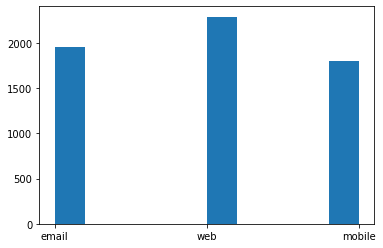

In [25]:
plt.hist(q4_nps['source'])
plt.show()

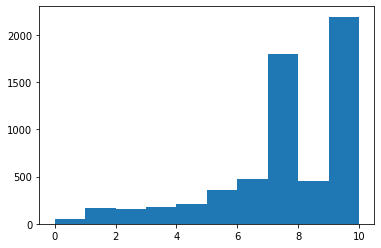

In [26]:
plt.hist(q4_nps['nps_rating'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


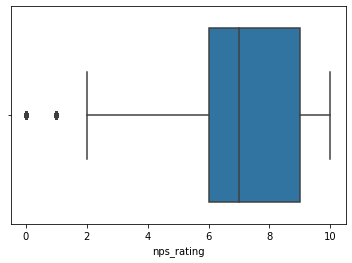

In [13]:
sns.boxplot(q4_nps["nps_rating"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


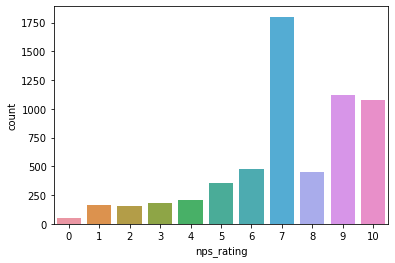

In [14]:
sns.countplot(q4_nps["nps_rating"])

In [ ]:
q4_nps = q4_nps.csv

In [ ]:
q4_nps.to_csv('q4_nps.csv')

In [ ]:
from google.colab import files
files.download('q4_nps.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>